<a href="https://colab.research.google.com/github/aquapathos/BasicAI/blob/master/4-2SOM/SOMExShare2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color=red>**ファイルメニューで「ドライブにコピー」し，コピー上で作業すること，**</font>






# 自己組織化マップとクラスタリングによるデータ分析

## 注意１

　まず、レポート課題に添付されたサンプルデータを使って、SOMとK-means法を使ったデータ解析法を理解してください。サンプルを使った実行はあくまでも練習です。サンプルデータについては、クラスタ分割の結果（画像）だけ報告してください。サンプルについての分析は不用です。

　<font color=red size=4>メインの課題は、自分で解析のテーマを設定し、自分で用意したデータデータ分析することです。</font>


## 注意２
　これはGoogle Colaboratory 用のプログラムファイルです。Chrome以外のブラウザでは不具合が発生する可能性があります。（新EdgeはChromeエンジンなのでたぶん大丈夫)

**（準備）**

<img width="350" alt="upload" src="https://user-images.githubusercontent.com/5820803/128598102-69d9fdb1-65f2-4a85-8403-1e12fb1edd30.png">

　左のファイルツリーのエリアに、**jinkoUTF8.csv** と **kendata.csv** をアップロードし、プログラムのセルを実行していってください。

　<font color=red>自分で作ったデータで実行する場合は、そのファイルをアップロードし、プログラム中の jinkoUTF8.csv という部分を自分のデータのファイル名に書き換えて実行してください。もしくは、ファイル名の方を合わせてもかまいません。</font>

# 依存ライブラリ

In [1]:
!pip -qq install japanize-matplotlib
!pip -qq install somoclu
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib

from sklearn.preprocessing import StandardScaler # 標準化のライブラリ
from sklearn.decomposition import PCA # 主成分分析のライブラリ
from sklearn.cluster import KMeans # k-means法のライブラリ
from somoclu import Somoclu # SOM のライブラリ

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 31.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


# １．　処理対象データとその前処理｀

[都道府県データランキング](http://uub.jp/pdr/)

（サンプルデータの説明）上のデータランキングのデータを適当に組合せて、kendata.csv というデータを作成した。ここでは説明のために、さらに人口、面積、人口密度の３つの項目だけを抜き出したデータ、<font color='red'>jinkoUTF8.csv</font> を使ってプログラムの一連の流れを説明します。 生データは一番下にしてあります。<font color='red'>独自のデータで実験する場合、項目は少なくとも３つ以上用いてください。２つ以下ではSOMを使う意味がありません。</font>

# １.1 データの読み込み

In [3]:
data = pd.read_csv("jinkoUTF8.csv", delimiter=",",encoding='utf-8',index_col=0)  # Windows版 Excel の csv ファイルの場合 encoding="cp932"
# data = pd.read_csv("kendata.csv", delimiter=",",encoding='utf-8',index_col=0)  # Windows版 Excel の csv ファイルの場合 encoding="cp932"
dataindex = data.columns # データ項目
pref = data.index # 都道府県名のリスト（１列目だけ取り出して pref に代入）
data.head() # 上から５データ分表示

,人口,面積,人口密度
都道府県,,,
北海道,5228885,78421.39,66.68
青森県,1238730,9645.64,128.42
岩手県,1211206,15275.01,79.29
宮城県,2303487,7282.29,316.31
秋田県,960113,11637.52,82.50


## (解説)
１行目　　Excel ファイルを読み込んで、 data というpandas配列に格納。（※）  
３行目　　head() は先頭から５つ分を取り出す関数。読み込みが成功しているかどうかの確認

<font color='red'> ※　自分でExcelデータを作る場合、データに日本語（全角文字）が含まれているときは、漢字コードに注意が必要です。

Windows は歴史的に ShiftJIS と呼ばれる漢字コードを使用してきたため、Windows版Excelの CSV 形式の書き出しでは、ShiftJISコード(cp932)がデフォルトになっています。最近の Excle は「CSV UTF-8」 での書き出しが選べるようになっています。

このプログラムは UTF-8形式を前提としています。もし、Excelで自分でデータを造る際には、<font color='red'>保存形式として「CSV UTF-8」</font>を選んでください。古いソフトを使っていて、「CSV UTF-8」で保存できない場合は csv 形式を選び、プログラムの  **encoding="utf8"** というところを、 **encoding="cp932"** と修正してください。macOSの場合は元々デフォルトが utf8 ですので csv 形式を選ぶだけでOKです．

</font>

# サンプルデータ（人口、面積、人口密度）
読み込んだデータは、都道府県別の「人口、面積、人口密度」のデータです。

このデータを用いて、自己組織化マップSOMを用いたデータ分析の例を示します。


# 1.2 標準化
一般にデータは項目ごとに尺度や範囲が異なる．例えば同じ１違いでも，身長における１mの違いと，体重の１Kgの違いは全然意味合いが異なる．身長が平均より１m大きいというのは非常に特異なことだが，体重が平均より１Kg重いのは特別なことではない．

データ分析では，そのような尺度や範囲の違いを気にせずに，同じ基準でデータを俯瞰したり分析したりすることができるよう，データを**標準化**、もしくは**正規化**して分析するのが一般的である。

**「標準化」**とは、与えられたデータを平均値が０、標準偏差が１となるように線形変換することである。また、**「正規化」**とは、与えられたデータをちょうど０～１の範囲に収まるように線形変換することをいう。

Pythonには標準化や正規化のためのクラスライブラリが用意されているので、簡単に標準化、正規化が実行できる。

ここでは**標準化**を用いることにする。

## 標準化の実行

In [4]:
sc = StandardScaler() # 標準化作用素の生成
stdData = sc.fit_transform(data) # 標準化の実行
#  stdData には data が標準化されたデータが格納される。この操作で pandas dataframe から 普通の numpy 配列に変わる。
stdData[0:5] # 上から５つ表示

array([[ 0.91851279,  6.47962842, -0.48788225],
       [-0.52258078,  0.15720093, -0.4369014 ],
       [-0.53252141,  0.6746985 , -0.47746974],
       [-0.13803069, -0.06005746, -0.28175414],
       [-0.62320674,  0.34031078, -0.47481913]])

上のセルの実行で表示された三つの列は，左から人口，面積，人口密度を標準化した数値である．面積の最初の数値が突出して大きい．その数値は北海道の面積であり，北海道の面積がいかに突出しているのかがわかる．

# 1.3 主成分分析

In [5]:
# SOMに入れる前にPCA(主成分分析)して計算コスト削減を測る
MNUM = 3  # 第何成分までを使うか　必ず元のデータの項目数以下に設定しないといけない
PNUM = len(data.columns)
pca = PCA(n_components=MNUM)   # 主成分分析器のインスタンス作成
pcaData = pca.fit_transform(stdData)   # 主成分分析を実行し，各データを主成分で表現し直す
pcaData[:5]

array([[-0.4480049 ,  6.5445626 , -0.18780667],
       [-0.69128636,  0.06522333, -0.08096129],
       [-0.78609019,  0.57068202, -0.15217988],
       [-0.2890971 , -0.0743555 ,  0.11374927],
       [-0.80904309,  0.22499303, -0.15645663]])

In [6]:
# 固有ベクトルの表示
eig_vec = pd.DataFrame(pca.components_.T, index = data.columns, \
                          columns = ["PC{}".format(x + 1) for x in range(MNUM)])
display(eig_vec)

# 固有値の表示
eig = pd.DataFrame(pca.explained_variance_, index=["PC{}".format(x + 1) for x in range(PNUM)], columns=['固有値']).T
display(eig)

# 寄与率
ev = pd.DataFrame(pca.explained_variance_ratio_, index=["PC{}".format(x + 1) for x in range(PNUM)], columns=['寄与率']).T
display(ev)

# 主成分得点
print('\n主成分得点　　各データを主成分で表現し直したベクトル（５つ目まで表示）')
cor = pd.DataFrame(pcaData, columns=["PC{}".format(x + 1) for x in range(PNUM)], index=pref)
display(cor.head())

,PC1,PC2,PC3
人口,0.694920,0.207674,0.688446
面積,-0.114192,0.977111,-0.179486
人口密度,0.709963,-0.046113,-0.702728


,PC1,PC2,PC3
固有値,1.95357,1.041108,0.07054


,PC1,PC2,PC3
寄与率,0.637335,0.339652,0.023013



主成分得点　　各データを主成分で表現し直したベクトル（５つ目まで表示）


,PC1,PC2,PC3
都道府県,,,
北海道,-0.448005,6.544563,-0.187807
青森県,-0.691286,0.065223,-0.080961
岩手県,-0.786090,0.570682,-0.152180
宮城県,-0.289097,-0.074355,0.113749
秋田県,-0.809043,0.224993,-0.156457


## 分析
　人口，面積，人口密度の場合，第１主成分は人口と人口密度の軸で張られる平面内で人口と人口密度を合成した値，　第２成分は面積とほぼ同義，第３主成分は面積平面内で第１主成分と直交する方向となっています．

　PC3の寄与率は０に近いので，　各データをおおまかに分析したい場合は，PC1,PC2の組み合わせで捉えればいい、とわかります．

----
　この例では要因が３つしかないので、こういう分析はあまりありがたみが感じられませんが，データ項目が大量にある場合は、どの要素が重要でどの項目が重要でないか、よって考慮から切り捨ててよいかといったことを篩（ふるい）にかけることができます．

# ２．　SOM 自己組織化マップ

ここでは、マップを構成する競合層ニューロンを、20ｘ30=600個とします。

個々のニューロンのシナプスの数は入力データの次元で決まります。サンプルデータの場合は都道府県データから３項目を取り出して使っているので入力は３次元ベクトル。よって入力層ニューロンは３個、競合層の600個のニューロンはそれぞれ３つずつ重みデータを持つことになります。

<img width="491" alt="重み" src="https://user-images.githubusercontent.com/5820803/93285327-9074e800-f80f-11ea-807d-af44210c790d.png">

SOMフォルダにある kendata.csv には８項目からなるデータが収められています。そちらを使う場合は、各データが８次元なので、重みは８つずつとなります。この場合、シナプスの数は、20×30×８で、計4800となります。計算時間は次元数やマップのサイズに比例します。


In [7]:
# SOMの設定
row = 20  # マップの高さ
col = 30 # マップの幅
epochs = 300 # 繰り返し学習回数
som = Somoclu(n_rows=row, n_columns=col,
#              initialization='pca', verbose=2, compactsupport=False, maptype='planar')  # toroid
              initialization='random', verbose=2, compactsupport=False, maptype='planar')  # toroid

##### 補足
　initialization は　競合層の重みの初期値の設定で， 'pca' と　’random' の２通りが選べます．　’pca' は主成分分析の結果に基づいて初期値を決めることを意味します．その場合，同じデータに対してSOMは決定論的に振る舞います．つまり，同じでデータに対して，同じパラメータで学習を実行したら，できるマップは同じになります．

ここでは　'random' を指定しているので、実行するたびに結果は変わります．

## 3. 競合学習

CPU times: user 3.52 s, sys: 103 ms, total: 3.63 s
Wall time: 6.18 s


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

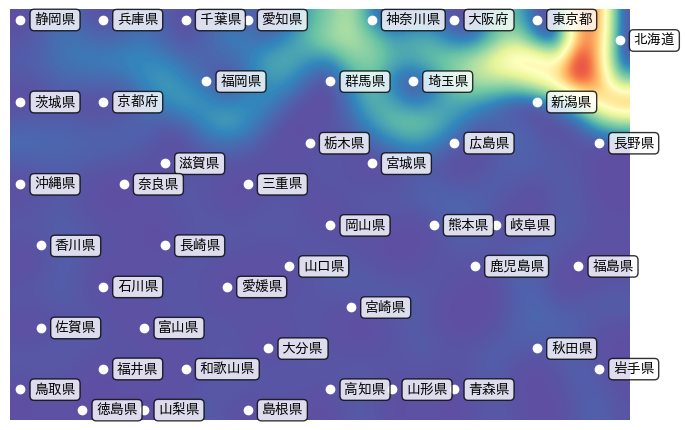

In [8]:
%%time
# 競合学習の実行
som.train(pcaData.astype(np.float32), epochs=epochs)  # 競合学習を実行
som.view_umatrix(bestmatches=True, labels=pref, filename='som1.png') # SOMの可視化

　マップの色はデータ間の隔たりの大きさを表しています．青が濃い箇所は隣接ノードとの成分の差が小さく、赤が濃くなるほど差が大きいことを意味します．

　通常、北海道が単独で濃いめの赤い帯で囲まれます。これは、このデータにおいて北海道が他の都道府県とは別格であることを意味します．

　また、東京・神奈川・大阪は近くに集まっていて、黄色い帯で囲まれるはずです．　これら３つの自治体もこのデータにおいては他の都道府県と差が


　競合学習が終わると、20ｘ30＝600個の3次元データが得られます。この600個のデータをk-means法でクラスタリングし，各クラスタにカラーを割り当てて表示してみます．


# ４ ．SOMのクラスタリング
## ４.1 クラスタリングのプログラム


In [9]:
# クラスタリング結果の描画
def plotClusterMap(som, km, pref, cmap='Pastel1'):

    fig, ax = plt.subplots(figsize=(10,6))
    ax.invert_yaxis()
    ax.axis('off')

    row = som._n_rows
    col = som._n_columns
    labels = som.clusters
    colors = plt.get_cmap('tab10')

    YY,XX = np.mgrid[0:row, 0:col] # make a grid

    ax.pcolormesh(XX, YY, labels, cmap=cmap,zorder=-10)

    centers = som.get_bmus(som.get_surface_state(km.cluster_centers_))

    for index, (x,y) in enumerate(centers):
        ax.text(x,y,str(index),ha='center', va='center',
           bbox=dict(facecolor='white', alpha=0.3, lw=0))

    for index in range(len(pref)):
        x = som.bmus[index][0]
        y = som.bmus[index][1]
        ax.scatter(x, y,  marker='o', s=30, label=pref[index], color=colors(som.clusters[y,x]))
        ax.annotate(pref[index], xy=(x,y), xytext=(10, -5),
                              textcoords='offset points', ha='left',
                              va='bottom', fontsize='small',
                              bbox=dict(boxstyle='round,pad=0.3',
                                        fc='white', alpha=0.1))

# 4.2 クラスタリング実験

## 4.2.1 実験前の考察

#### データについての考察
　jinkoUTF8.csv というデータは、「人口」「人口密度」「面積」の３項目からなります。「人口密度」は「人口」と「面積」のデータから計算できるデータです。深いネットワークであれば階層を経ることで「人口」と「面積」だけでも、中間層ニューロンが「人口密度」の役割を果たすことができるので「人口密度」は不要かもしれませんが、今回用いるニューラルネットワークは入力層が直接競合層と結びつけられたもっと単純な層構成なので、「人口密度」のデータがなければ、「人口密度」が基準となるようなクラスタが発生するということは期待できません。

#### クラスタ数ごとの、生成されるクラスタの予想シナリオ

#### （１）２クラスタ
2クラスタの場合、次のようなクラスタ分割の可能性が予想できます。
- （予想シナリオ１） 北海道の面積が突出しているので、北海道とそれ以外というクラスタ分割が行われる。
- （予想シナリオ２）人口または人口密度基準で、東京、神奈川、大阪などの人口の密集した大都会を擁する都道府県が他と分離される

#### （２）３クラスタ
３クラスタの場合、次のようなクラスタ分割の可能性が予想される。
- （予想シナリオ１）2クラスタにおける２つの予想が組み合わさって、大都市クラスタ、北海道、その他という3クラスタが発生する。
- （予想シナリオ２）（１）超大都市圏（東京、神奈川、大阪）、（２）埼玉、神戸、愛知などの大都市圏（３）その他の地方とで3クラスタとなる。

## 4.2.2 実験
### (1) データをk-means法で２分割

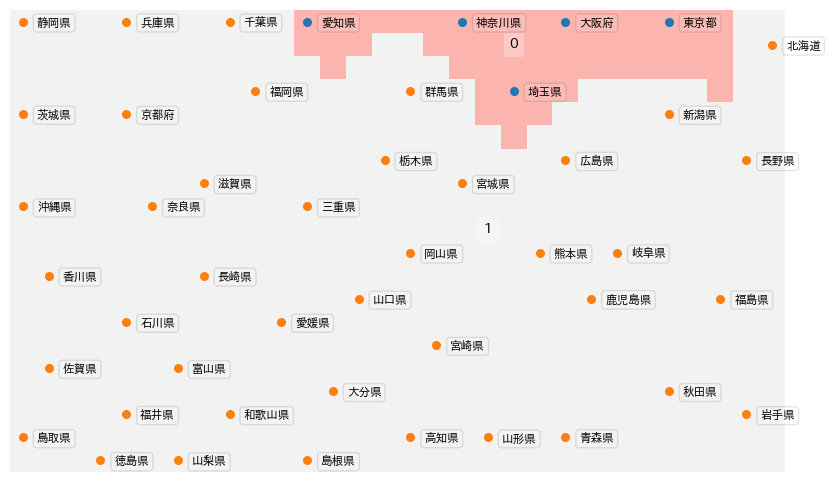

In [10]:
km = KMeans(n_clusters=2, init = 'k-means++', n_init='auto', random_state=None)
som.cluster(algorithm=km)
plotClusterMap(som, km, pref)
plt.savefig("som2.png");

### （実験結果についての考察の例）

><img width="377" alt="dample" src="https://user-images.githubusercontent.com/5820803/93286733-da130200-f812-11ea-9eb8-b9dc7edd7a53.png">    
       　　　　　図〇〇　２クラスタ分割の結果    
 *２クラスタ分割の結果を図〇〇に示す。結果は予想シナリオ２に近いが、東京、大阪、神奈川に加えて、愛知、埼玉が同じクラスタとなり、他の都道府県と分離される結果となった。愛知は東京圏、大阪圏につぐ中部地方の中核であり、３大都市圏が同じクラスタとしてまとめられた形である。また、埼玉県は神奈川と同じで首都圏を構成する県であるということがわかる*。






**【注意】** 結果は乱数の初期値によりさまざまに変化します。何度かやってみればいくつかのパターンが現れるので試してみてください。なお、やり直す場合は「４　SOMのメインプログラム」のところから、再実行する必要があります。defだけの箇所は飛ばしてかまいません。

<img width="634" alt="result" src="https://user-images.githubusercontent.com/5820803/93287174-ce740b00-f813-11ea-9e99-e21deed09aee.png">


- シナリオ１の予想通りのケース
- シナリオ２の予想通りのケース
- シナリオ１と２が混ざり大都市に北海道が加わるケース
- 大都市クラスタに、福岡、兵庫なども加わるケース
など



### （2）データをk-means法で3分割


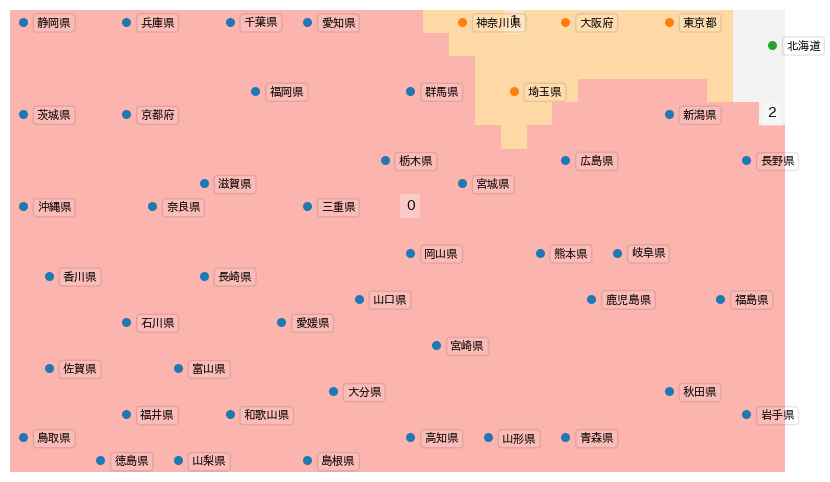

In [11]:
km = KMeans(n_clusters=3, init = 'k-means++', n_init='auto', random_state=None)
som.cluster(algorithm=km)
plotClusterMap(som, km, pref)
plt.savefig("som3.png");

### （実験結果についての考察の例）
 結果は3クラスタにおける（予想シナリオ１）の予想通りであるといえる。

# （3）データをk-means法で5分割

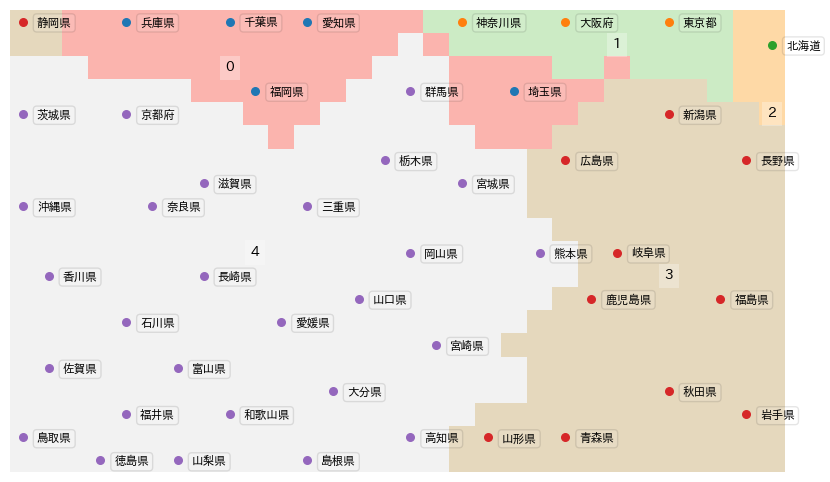

In [12]:
km = KMeans(n_clusters=5, init = 'k-means++', n_init='auto', random_state=None)
som.cluster(algorithm=km)
plotClusterMap(som, km, pref)
plt.savefig("som5.png");

### （実験結果についての考察の例）

  東京、大阪、神奈川という超大都市が大都市クラスタから分離し、残りの埼玉と愛知と、それらに次ぐ人口過密県である、千葉、兵庫、福岡が加わったクラスタが形成されたことがわかる。また、その他の県が２つのクラスタに分離しているが、これは面積で分離された可能性が高い

# 5 ．SOMを使った未知データの分析
学習後のSOMは、似たデータをMAP上の近くにマッピングするという性質をもちます。この性質を利用し、未知のデータが既知のデータのどれに近いかや、どのクラスタに分類されるべきかを分析することができます。

### ニューヨーク州、香港、ハワイ州がどの県に近いかをプロットしてみる。

上で定義してある、**get_winner(W,data)** という関数は、データ data を二次元マップに写像し、その座標を返してきます。その位置を完成したSOMにプロットしてみます。


In [13]:
dataindex

Index(['人口', '面積', '人口密度'], dtype='object')

Text(28.5, 14.5, 'Hawai')

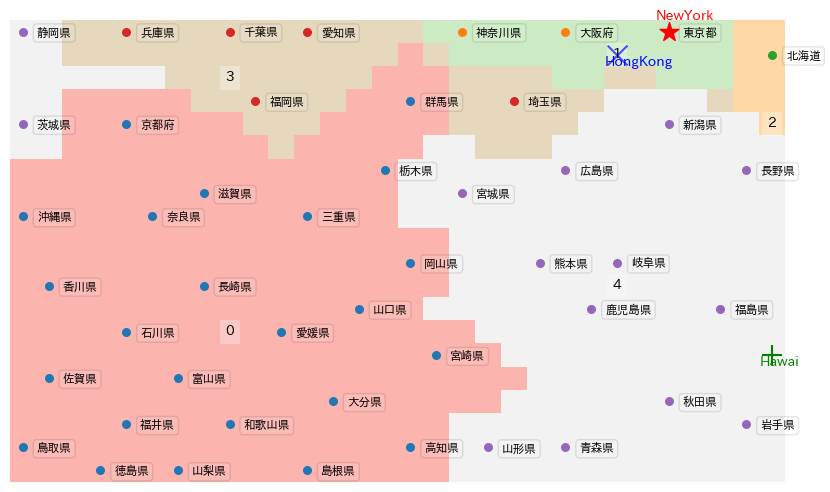

In [14]:
#　データのリスト　data の各データともっとも近い重みベクトルを持つノードの座標リストを得る
def get_winner(som,sc,pca,data):
    scvecs = sc.transform(data)
    vecs = pca.transform(scvecs)
    bestmatches = som.get_bmus(som.get_surface_state(vecs))
    return bestmatches

#　ニューヨーク，　香港，　ハワイの　人口，面積，人口密度のデータ
newyork = [19541453,1413,19541453/1413]
hongkong = [7392000,1106,7392000/1106]
hawaii = [1428557,16634,1428557/16634]

# SOM 上で３つの都市のマッピング位置を得る
data = pd.DataFrame([newyork, hongkong, hawaii], columns=dataindex)
bmu = get_winner(som,sc=sc,pca=pca,data=data)  # Best Match Unit

nx, ny = bmu[0] # ニューヨークのデータに反応するニューロン位置
hox, hoy = bmu[1] # 香港のデータに反応するニューロン位置
hwx, hwy = bmu[2] # ハワイのデータに反応するニューロン位置

# 5クラスタのマップに３都市をプロット

km = KMeans(n_clusters=5, init = 'k-means++', n_init='auto', random_state=None)
som.cluster(algorithm=km)
plotClusterMap(som, km, pref)

plt.scatter(nx,ny,s=200,marker='*',color='red') # ニューヨークは☆印
plt.text(nx-0.5,ny-+0.5,"NewYork",color='red')
plt.scatter(hox,hoy,s=200,marker='x',color='blue') # 香港はX印
plt.text(hox-0.5,hoy+0.5,"HongKong",color='blue')
plt.scatter(hwx,hwy,s=200,marker='+',color='green') # ハワイは＋印
plt.text(hwx-0.5,hwy+0.5,"Hawai",color='green')

この実験により、
1. ニューヨーク州は日本で言えば東京都と似た人口、面積をもつ
2. 香港は日本で言えば東京都、大阪府、神奈川県と、人口、面積において類似しており、大阪府に近い。
3. ハワイは人口や面積、人口密度という観点で見れば、日本の東北地方に近い。


# <font color='red'>課題</font>

1. 添付されたデータでSOMを使ったデータ分析手順を理解する。クラスタリングの結果（２クラスタ、3クラスタ）をレポート（例なので図だけ記載すればいい。分析は不用）   
2. Webで公開されているデータを加工して、独自の実験用データを作成、  
3. 入手先やどの項目を使ったかを正確にレポートに記述し、独自データでデータ分析を実行。

- 実行前の予想、結果の図、結果の分析をレポートに記述してください。
- 乱数が使われているのでクラスタリング結果は1通りではありません。同じデータに対して複数回実行してみてください。


# 付録　使用したデータ

In [15]:
with open("jinkoUTF8.csv", encoding="utf-8") as f:
    print(f.read())

﻿都道府県,人口,面積,人口密度
北海道,5228885,78421.39,66.68
青森県,1238730,9645.64,128.42
岩手県,1211206,15275.01,79.29
宮城県,2303487,7282.29,316.31
秋田県,960113,11637.52,82.5
山形県,1068696,9323.15,114.63
福島県,1834198,13784.14,133.07
茨城県,2868554,6097.39,470.46
栃木県,1934016,6408.09,301.81
群馬県,1940333,6362.28,304.97
埼玉県,7346836,3797.75,1934.52
千葉県,6287034,5157.57,1218.99
東京都,14064696,2194.03,6410.44
神奈川県,9240411,2416.11,3824.5
新潟県,2202358,12583.96,175.01
富山県,1035612,4247.58,243.81
石川県,1133294,4186.21,270.72
福井県,767433,4190.52,183.14
山梨県,810427,4465.27,181.5
長野県,2049683,13561.56,151.14
岐阜県,1979781,10621.29,186.4
静岡県,3635220,7777.35,467.41
愛知県,7546192,5173.07,1458.75
三重県,1771440,5774.49,306.77
滋賀県,1414248,4017.38,352.03
京都府,2579921,4612.2,559.37
大阪府,8842523,1905.32,4640.96
兵庫県,5469184,8401.02,651.01
奈良県,1325437,3690.94,359.11
和歌山県,923033,4724.65,195.37
鳥取県,553847,3507.14,157.92
島根県,671602,6707.69,100.12
岡山県,1889607,7114.33,265.61
広島県,2801388,8479.65,330.37
山口県,1342987,6112.54,219.71
徳島県,719704,4146.75,173.56
香川県,951049

In [16]:
with open("kendata.csv", encoding="utf-8") as f:
    print(f.read())

﻿都道府県,人口,面積,人口密度,外国人,国籍不詳率,公務員,産業動物,小動物診療
北海道,5352306,78421,68,18280,0.001,3427,688,1080
青森県,1293619,9646,134,3688,0.0019,546,193,74
岩手県,1268083,15275,83,5184,0.0019,628,137,162
宮城県,2329431,7282,320,12367,0.0043,653,199,125
秋田県,1009705,11638,87,3356,0.0037,301,110,42
山形県,1113029,9323,119,6158,0.0014,358,114,73
福島県,1900106,13784,138,9347,0.0038,529,133,108
茨城県,2907262,6097,477,40477,0.0022,1145,216,124
栃木県,1968425,6408,307,26429,0.0081,710,179,116
群馬県,1966381,6362,309,35458,0.0042,647,186,107
埼玉県,7288081,3798,1919,88734,0.0071,1967,345,73
千葉県,6240408,5158,1210,78927,0.0183,1878,402,145
東京都,13636222,2191,6224,318829,0.0165,4025,535,42
神奈川県,9145572,2416,3786,125686,0.0084,2715,514,41
新潟県,2285856,12584,182,11914,0.003,514,155,38
富山県,1061393,4248,250,11002,0.0031,270,104,16
石川県,1150818,4186,275,9768,0.0044,254,68,10
福井県,782232,4190,187,10562,0.0054,163,45,8
山梨県,829884,4465,186,12484,0.0025,217,74,8
長野県,2087997,13562,154,29841,0.0016,761,197,66
岐阜県,2022785,10621,190,36879,0.0032,664,215,36
静

# 日本語フォントに関する補足説明

旧来、Windowsでは日本語フォントとして 「シフト JIS コード ＝ cp932」が用いられてきた。最近は世界共通のマルチバイトフォントの仕様である  Unicode にシフトしている。Macはほぼ完全にシフトしているし、python 言語も Unicode がデフォルトである。Windowsも Unicode が使われているが、日本語オフィス環境ではいまだ Shift JIS が用いられており、Excelでも、指定しなければシフトJISコードが使われる。

Windows版日本語Excelは特に指定せずに csv 形式で保存するといまだシフトJISコードが用いられる（時代遅れである）。Unicode形式で保存したければ、ファイルの種類として 「**CSV UTF-8 (コンマ区切り）**」を選べばよい。

上のセルでは説明上、明示的に

``` encoding =utf-8 ```

と指定したが、python は utf-8 がデフォルトであるので、utf-8 の場合は無指定でよい。